# Классы

In [67]:
import numpy as np
from numba import njit
import seaborn as sns
sns.set_theme()

In [68]:
class ZeroCrossingSignal:

    def __init__(self, signal, harmonic_hf, start_offset, start_period):
        self.__amplitudes, self.__phases, self.__biases = self.zero_crossing(signal, harmonic_hf, start_offset, start_period)

    @staticmethod
    @njit
    def zero_crossing(signal, harmonic_hf, start_offset, start_period):
        offset = start_offset
        period = start_period

        amplitudes = [1.,]
        phases = [1.,]
        biases = [1.,]

        amplitudes.pop()
        phases.pop()
        biases.pop()

        harmonics_vector = np.array([0., 0., 0.])
        iteration = 0

        while offset < (len(signal) - np.floor(period)-1):
            phase = 2 * np.pi / period * harmonic_hf # связано со временеи обората, длинна сгустка - bunch ## похоже на фазу 
 
            harmonics_vector[0] = np.sum(signal[offset:offset + int(period) + 1] * np.cos(phase * np.arange(int(period) + 1)))
            harmonics_vector[1] = np.sum(signal[offset:offset + int(period) + 1] * np.sin(phase * np.arange(int(period) + 1)))
            harmonics_vector[2] = np.sum(signal[offset:offset + int(period) + 1])
 
            P_b = np.array(((0., 0., 0.),
                            (0., 0., 0.),
                            (0., 0., 0.)))

            cos_vals = np.cos(phase * np.arange(int(period) + 1))
            sin_vals = np.sin(phase * np.arange(int(period) + 1))

            P_b[0, 0] = np.sum(cos_vals**2)
            P_b[0, 1] = np.sum(cos_vals * sin_vals)
            P_b[0, 2] = np.sum(cos_vals)
            P_b[1, 0] = P_b[0, 1]
            P_b[1, 1] = np.sum(sin_vals**2)
            P_b[1, 2] = np.sum(sin_vals)
            P_b[2, 0] = P_b[0, 2]
            P_b[2, 1] = P_b[1, 2]
            P_b[2, 2] = int(period) + 1

            A = np.linalg.inv(P_b) @ harmonics_vector # ----
     
            amplitudes.append(np.sqrt(A[0]**2 + A[1]**2)) # амплитуда 
            phases.append(offset + (1 / phase * np.arctan2(A[0], -A[1]))) # фаза 
            biases.append(A[2]) # ----
 
            offset = int(phases[iteration] + period) # перечет офсета 

            period = 1 / 10 * (phases[iteration] - phases[iteration-10]) if iteration > 12 else period # перечсет периода для окна 

            iteration += 1

        return np.array(amplitudes), np.array(phases), np.array(biases)
        
    @property
    def amplitudes(self): return self.__amplitudes

    @property
    def phases(self): return self.__phases

    @property
    def biases(self): return self.__biases

In [69]:
class LorentzFactors:
    def __init__(self, phases, booster_perimeter, delta_time, nuclone_mass, speed_of_light=2.997925e10):
        self.__phase_difference = np.diff(phases)
        self.__beta = booster_perimeter / (speed_of_light * delta_time * self.phase_difference)
        self.__gamma = 1 / np.sqrt(1 - self.beta**2)
        self.__energy = (self.gamma-1) * nuclone_mass

    @property
    def phase_difference(self): return self.__phase_difference

    @property
    def beta(self): return self.__beta

    @property
    def gamma(self): return self.__gamma

    @property
    def energy(self): return self.__energy

In [70]:
class AveragedData:
    def __init__(self, phases, corrected_phases, intensities, averaging_window):
        self.__phases = self.average_data(phases, averaging_window)
        self.__corrected_phases = self.average_data(corrected_phases, averaging_window)
        self.__intensities = self.average_data(intensities, averaging_window)
    
    @property
    def phases(self): return self.__phases

    @property
    def corrected_phases(self): return self.__corrected_phases

    @property
    def intensities(self): return self.__intensities
    
    @staticmethod
    def average_data(data, averaging_window):
        return np.convolve(data, np.ones(averaging_window)/averaging_window, mode='valid')[::averaging_window]

In [71]:
class ParametersFCTRF:
    def __init__(self, signal_fct, signal_rf, period, offset_fct, offset_rf, offset_between_signals,
                 harmonic_hf, booster_perimeter, delta_time, averaging_window_for_finding_fct_minimums,
                 averaging_window, nuclone_mass = 938.256e6, phase_offset=0, charge_number = 28,
                 electron_charge = 1.6021e-19, speed_of_light = 2.997925e10):

        self.__signal_fct = signal_fct
        self.__signal_rf = signal_rf
        self.__period = period
        self.__offset_fct = offset_fct
        self.__offset_rf = offset_rf
        self.__delta_time = delta_time
        self.__booster_perimeter = booster_perimeter
        self.__offset_between_signals = offset_between_signals

        self.__zero_crossing_rf = ZeroCrossingSignal(signal_rf, harmonic_hf, offset_rf, period)
        self.__phases = self.__zero_crossing_rf.phases
        # Зачем скипать 1, а потом и phase_offset?
        self.__discretized_phases = np.floor(self.zero_crossing_rf.phases[1:]).astype(int)
        self.__discretized_phases_with_offset = self.discretized_phases[phase_offset:]
        self.__fct_minimums = self.signal_minimums_with_averaging(signal_fct[offset_between_signals:], self.discretized_phases_with_offset,
                                                                averaging_window_for_finding_fct_minimums)
        self.__corrected_phases = self.correct_phases(signal_fct[offset_between_signals:], self.fct_minimums, self.zero_crossing_rf.phases,
                                                      phase_offset, harmonic_hf)

        self.__intensities = self.find_intensities(signal_fct[offset_between_signals:], self.fct_minimums, self.discretized_phases_with_offset,
                                        delta_time, charge_number=charge_number, electron_charge=electron_charge)    

        self.__averaged_data = AveragedData(np.hstack((np.zeros(phase_offset), self.phases[phase_offset: -phase_offset])),
                                            np.hstack((np.zeros(phase_offset), self.corrected_phases)),
                                            np.hstack((np.zeros(phase_offset), self.intensities)),
                                            averaging_window)

    @property
    def signal_fct(self): return self.__signal_fct

    @property
    def signal_rf(self): return self.__signal_rf

    @property
    def offset_fct(self): return self.__offset_fct

    @property
    def offset_rf(self): return self.__offset_rf
    
    @property
    def delta_time(self): return self.__delta_time

    @property
    def period(self): return self.__period

    @property
    def booster_perimeter(self): return self.booster_perimeter

    @property
    def phases(self): return self.__phases

    @property
    def zero_crossing_rf(self): return self.__zero_crossing_rf

    @property
    def lorentz_factors(self): return self.__lorentz_factors

    @property
    def discretized_phases(self): return self.__discretized_phases

    @property
    def discretized_phases_with_offset(self): return self.__discretized_phases_with_offset

    @property
    def fct_minimums(self): return self.__fct_minimums

    @property
    def corrected_phases(self): return self.__corrected_phases

    @property
    def averaged_phases(self): return self.__averaged_phases

    @property
    def intensities(self): return self.__intensities

    @property
    def averaged_data(self): return self.__averaged_data

    @staticmethod
    @njit
    def correct_phases(signal, signal_minimums, phases, phase_offset, harmonic_hf): #Что за коррекция фаз? Что вообще тут происходит
        discretized_phases = phases[1:].astype('int32')
        corrected_phases = np.zeros(len(discretized_phases) - phase_offset - 1, dtype=float)

        for i in range(len(corrected_phases)):
            up_sum = np.sum((signal[discretized_phases[phase_offset+i]: discretized_phases[phase_offset+i+1]+1] - signal_minimums[i])*\
                            (np.arange(discretized_phases[phase_offset+i+1]-discretized_phases[phase_offset+i]+1) + discretized_phases[phase_offset+i] -\
                               (phases[phase_offset+i+2] + phases[phase_offset+i+1]) / 2))
            under_sum = np.sum(signal[discretized_phases[phase_offset+i]:
                                    discretized_phases[phase_offset+i+1]+1] - signal_minimums[i])
            corrected_phases[i] = 360 * harmonic_hf / (discretized_phases[phase_offset+i+1] - discretized_phases[phase_offset+i]) * (up_sum / under_sum)
        
        return corrected_phases

    @staticmethod
    @njit
    def find_intensities(signal, signal_minimums, phases, delta_time, charge_number = 28, electron_charge=1.6021e-19):
        intensities = np.zeros((len(phases)-1))
        for i in range(len(phases)-1):
            intensities[i] = 8.6 * 10**(-5) * (10**(-3) / (5 * charge_number)) *\
            (delta_time / electron_charge) * np.sum(signal[phases[i]: phases[i+1] + 1] - signal_minimums[i]) / 10
        return intensities 

    @staticmethod
    @njit
    def signal_minimums_with_averaging(signal, period_nodes, window_length):
        result = np.zeros(len(period_nodes)-1)
        for i in range(len(period_nodes)-1):
            result[i] = np.convolve(signal[period_nodes[i]: period_nodes[i+1]], np.ones(window_length) / window_length)[window_length-1: -window_length+1].min()
        return result

In [72]:
# class PlotParametersFCTRF(ParametersFCTRF):
#     def two_periods_signals_plot(self, first_period_number=0, last_period_number=1500, figsize=(12, 6),
#                             rf_first_half_parameters={}, rf_second_half_parameters={},
#                             fct_first_half_parameters={}, fct_second_half_parameters={}):
#         plt.figure(figsize=figsize)
        
#         period_range = np.arange(self.period, dtype=int)
#         signal_rf_first_slice = self.signal_rf[first_period_number*period_range[-2] + period_range + self.offset_rf]
#         signal_rf_last_slice = self.signal_rf[last_period_number*period_range[-2] + period_range + self.offset_rf]
#         signal_fct_first_slice = self.signal_fct[first_period_number*period_range[-2] + period_range + self.offset_fct]
#         signal_fct_last_slice = self.signal_fct[last_period_number*period_range[-2] + period_range + self.offset_fct]

#         plt.plot(period_range, signal_fct_first_slice, label=f'{first_period_number} period FCT')
#         plt.plot(period_range, signal_fct_last_slice, label=f'{last_period_number} period FCT')
#         plt.legend()

#         plt.twinx()

#         plt.plot(period_range, signal_rf_first_slice, label=f'{first_period_number} period RF')
#         plt.plot(period_range, signal_rf_last_slice, label=f'{last_period_number} period RF')

#         plt.legend()

#         plt.xlim([0, self.period])

#     def lorentz_factor_plot(self, factor_name, figsize=None, **kwargs):
#         if figsize: plt.figure(figsize=figsize)
#         y = getattr(self.lorentz_factors, factor_name.lower())
#         x = self.delta_time * np.arange(len(y))
#         plt.plot(x, y, **kwargs, label=factor_name)
#         plt.xlabel('Time')
#         plt.title(f'{factor_name} Lorentz-factor',fontweight='bold')
#         plt.legend()

#     def phase_difference_plot(self, figsize=None, phase_difference_plot_parameters={}, period_line_plot_parameters={}):
#         if figsize: plt.figure(figsize=figsize)
#         y = self.lorentz_factors.phase_difference
#         x = self.delta_time * np.arange(len(y))
#         plt.plot(x, y, label='Phase difference', **phase_difference_plot_parameters)
#         plt.axhline(y=self.period, **period_line_plot_parameters, label=f'Initial period = {round(self.period, 2)}')
#         plt.legend()
#         plt.xlabel('Time')

In [73]:
class CombinedParametersFCTRF:
    def __init__(self, first_half, second_half):
        self.__first_half = first_half
        self.__second_half = second_half

    def __getitem__(self, key):
        if key == 'first_half': return self.first_half
        if key == 'second_half': return self.second_half
        raise KeyError('Key should be "first_half" or "second_half"')

    @property
    def first_half(self): return self.__first_half

    @property
    def second_half(self): return self.__second_half

In [74]:
# class PlotCombinedParametersFCTRF(CombinedParametersFCTRF):
#     pass

# Константы

In [75]:
mass_proton = 938.256 * 10**6 # масса покоя протона 
charge_electron  = 1.6021 * 10**(-19) # заряд электрона в Кл
speed_of_light = 2.997925 * 10**10

# Параметры

In [76]:
booster_perimeter = 21096 # периметр бустера в мм #ВЕЗДЕ ОДИН
delta_time = (50 * 10e5)**(-1) #ВЕЗДЕ ОДНО

# оффсеты по какой-то причине отличаются у некоторых, это нужно уточнить
offset_fct = 45 #нафиг не нужен в классе

#ОБЩИЕ ПАРАМЕТРЫ
booster_perimeter = 21096 # периметр бустера в мм
delta_time = (5e6)**(-1) 
offset_between_signals = 10
data_length = 7 * 32 * 128 * 1024 + 1
phase_offset = 2
averaging_window_for_finding_fct_minimums = 13
averaging_window = 20
bytes_to_skip_for_second_half = 68_000_000

In [77]:
half_names = 'first_half', 'second_half'
period = {'first_half': 425.067, 'second_half': 127.848}
harmonic_hf = {'first_half': 5, 'second_half': 1}
offset_rf = {'first_half': 10, 'second_half': 112}

In [78]:
signals_fct_filepaths = [r'data/booster_acceleration/27_01_23_booster_fct_1.bin', r'data/booster_acceleration/27_01_23_booster_fct_2.bin']
signals_rf_filepaths = [r'data/booster_acceleration/27_01_23_booster_rf_1.bin', r'data/booster_acceleration/27_01_23_booster_rf_2.bin']

In [79]:
signals_rf = []
signals_fct = []
for signal_fct_filepath, signal_rf_filepath in zip(signals_fct_filepaths, signals_rf_filepaths):
    signals_rf.append({'first_half': np.fromfile(signal_rf_filepath, dtype='int16')[:data_length],
                      'second_half': np.fromfile(signal_rf_filepath, dtype='int16', offset=bytes_to_skip_for_second_half)[:data_length]})

    signals_fct.append({'first_half': np.fromfile(signal_fct_filepath, dtype='int16')[:data_length],
                       'second_half': np.fromfile(signal_fct_filepath, dtype='int16', offset=bytes_to_skip_for_second_half)[:data_length]})

# Расчеты

In [80]:
parameters_fct_rf = []
for i in range(len(signals_rf)):
    part_separated = []
    for key in half_names:
        part_separated.append(ParametersFCTRF(signal_fct=signals_fct[i][key], signal_rf=signals_rf[i][key], period=period[key],
                                             offset_fct=offset_fct, offset_rf=offset_rf[key], offset_between_signals=offset_between_signals,
                                             harmonic_hf=harmonic_hf[key], booster_perimeter=booster_perimeter, delta_time=delta_time,
                                             phase_offset=phase_offset, averaging_window_for_finding_fct_minimums=averaging_window_for_finding_fct_minimums,
                                             averaging_window=averaging_window))
    parameters_fct_rf.append(CombinedParametersFCTRF(*part_separated))

In [81]:
number = 0
half_name = 'first_half'

# Графики по разным частям

In [82]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [83]:
# МЕСТО ДЛЯ ГРАФИКА 1

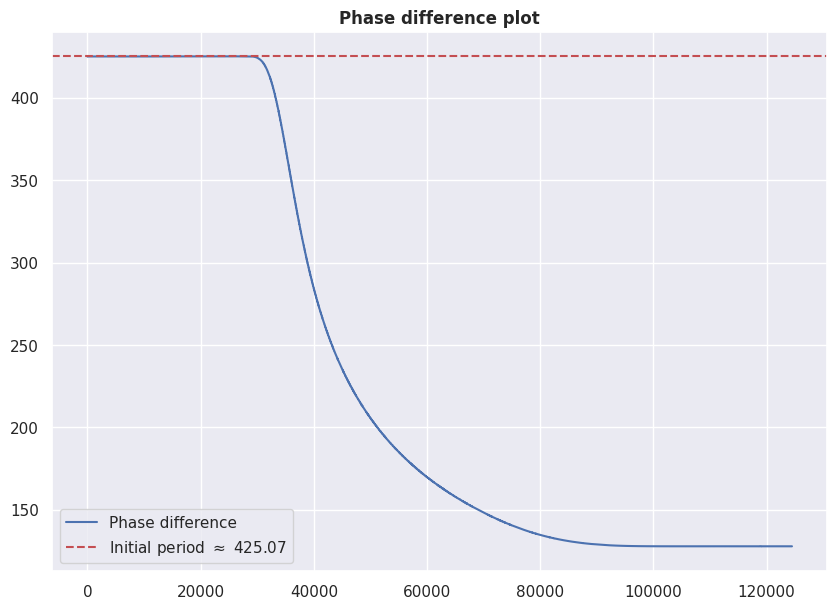

In [84]:
plt.figure(figsize=(10, 7))
y = np.diff(parameters_fct_rf[number][half_name].phases)
x = np.arange(len(y))
plt.plot(x, y, label='Phase difference')
plt.axhline(y=period[half_name], color='r', linestyle='--', label=f'Initial period $\\approx$ {round(period[half_name], 2)}')
plt.title('Phase difference plot',fontweight='bold')
plt.legend();

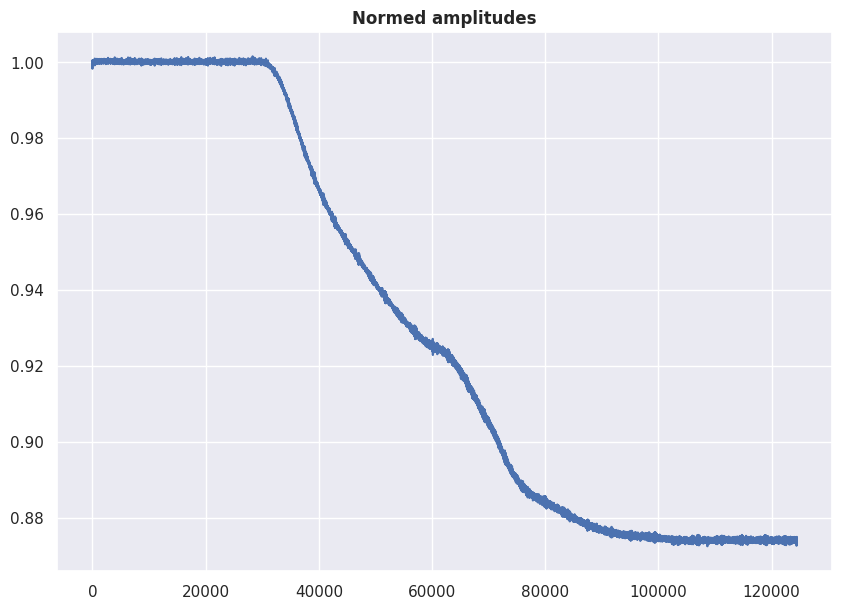

In [85]:
plt.figure(figsize=(10, 7))
y = parameters_fct_rf[number][half_name].zero_crossing_rf.amplitudes
x = np.arange(len(y))
plt.plot(x, y/y[0])
plt.title('Normed amplitudes',fontweight='bold');

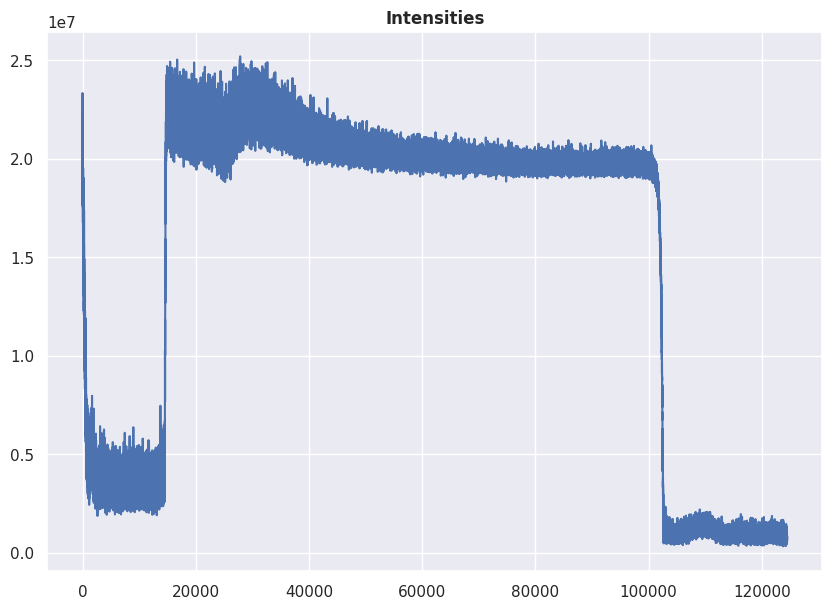

In [86]:
plt.figure(figsize=(10, 7))
y = parameters_fct_rf[number][half_name].intensities
x = np.arange(len(y))
plt.plot(x, y)
plt.title('Intensities',fontweight='bold');

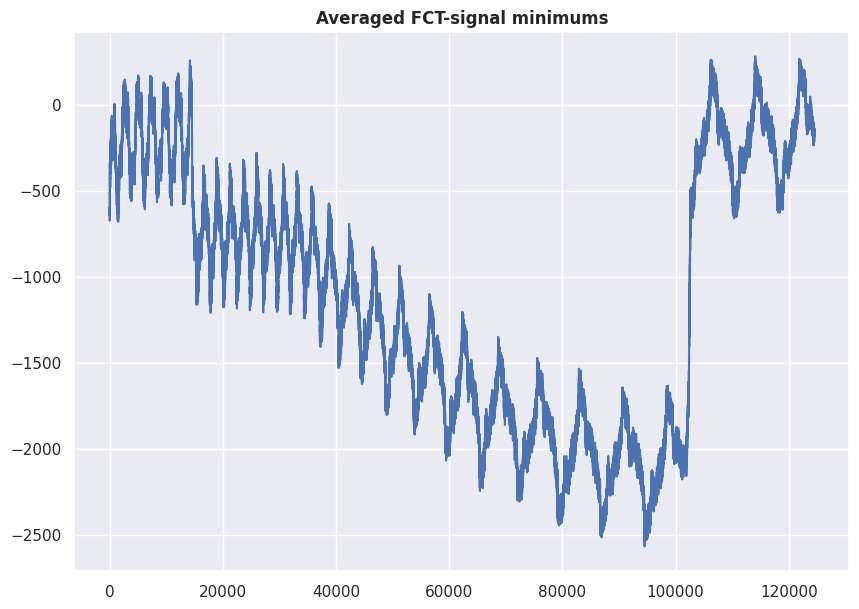

In [87]:
plt.figure(figsize=(10, 7))
y = parameters_fct_rf[number][half_name].fct_minimums
x = np.arange(len(y))
plt.plot(x, y)
plt.title('Averaged FCT-signal minimums',fontweight='bold');

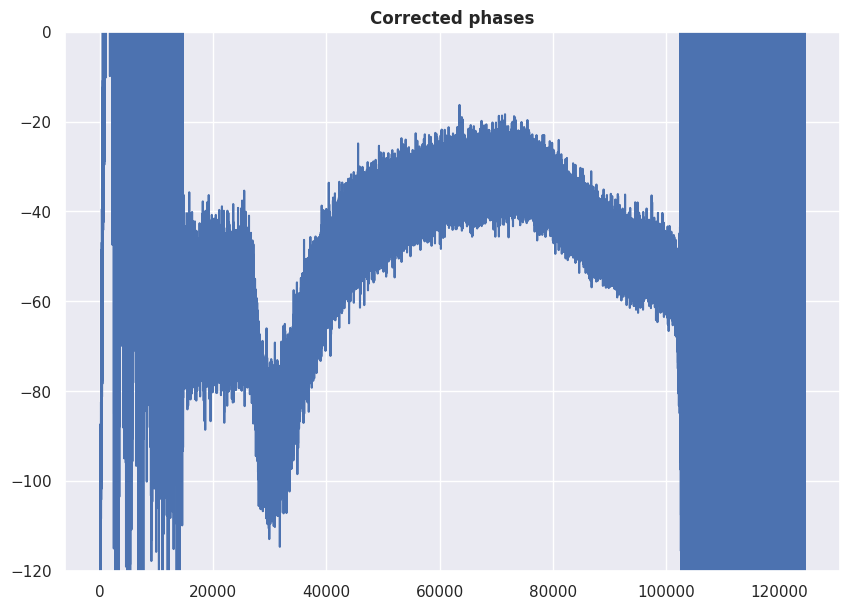

In [90]:
plt.figure(figsize=(10, 7))
y = parameters_fct_rf[number][half_name].corrected_phases
x = np.arange(len(y))
plt.plot(x, y)
plt.title('Corrected phases',fontweight='bold');
plt.ylim([-120, 0]);

In [100]:

# Создаем график Plotly
fig = go.Figure()

# Добавляем первый график на основную ось y
y = parameters_fct_rf[number][half_name].averaged_data.corrected_phases
x = np.arange(len(y))
fig.add_trace(go.Scatter(x=averaging_window * x, y=y, mode='lines', line=dict(color='red'), name='Corrected phases')) 

# Добавляем второй график на дополнительную ось y
y = parameters_fct_rf[number][half_name].averaged_data.intensities
fig.add_trace(go.Scatter(x=averaging_window * x, y=y[x], mode='lines',line=dict(color='blue'), name='Intetsities', yaxis='y2'))

# Настраиваем общий вид графика
fig.update_layout(
    title='',
    yaxis=dict(title='Corrected phases', range=[-120, -60]),
    yaxis2=dict(title='Intensities', overlaying='y', side='right')
)

# Изменяем размер окна графика
fig.update_layout(
    width=1200,   # Ширина окна в пикселях
    height=600   # Высота окна в пикселях
)

# Отображаем график
fig.show()

# Обработка результатов

In [ ]:
real_time = {}
real_time['first_half'] = delta_time * parameters_fct_rf[0]['first_half'].averaged_data.phases
real_time['second_half'] = delta_time * parameters_fct_rf[0]['second_half'].averaged_data.phases + bytes_to_skip_for_second_half/2 * delta_time

In [ ]:
real_time_data = []
for i in range(len(signals_rf)):
    real_time_data.append(
        {'first_half': delta_time * parameters_fct_rf[i]['first_half'].averaged_data.phases,
         'second_half': delta_time * parameters_fct_rf[i]['second_half'].averaged_data.phases + bytes_to_skip_for_second_half/2 * delta_time})

In [ ]:
real_time = []
for i in range(len(signals_rf)):
    real_time.append(
        {'first_half': delta_time * parameters_fct_rf[i]['first_half'].averaged_data.phases,
         'second_half': delta_time * parameters_fct_rf[i]['second_half'].averaged_data.phases + bytes_to_skip_for_second_half/2 * delta_time})

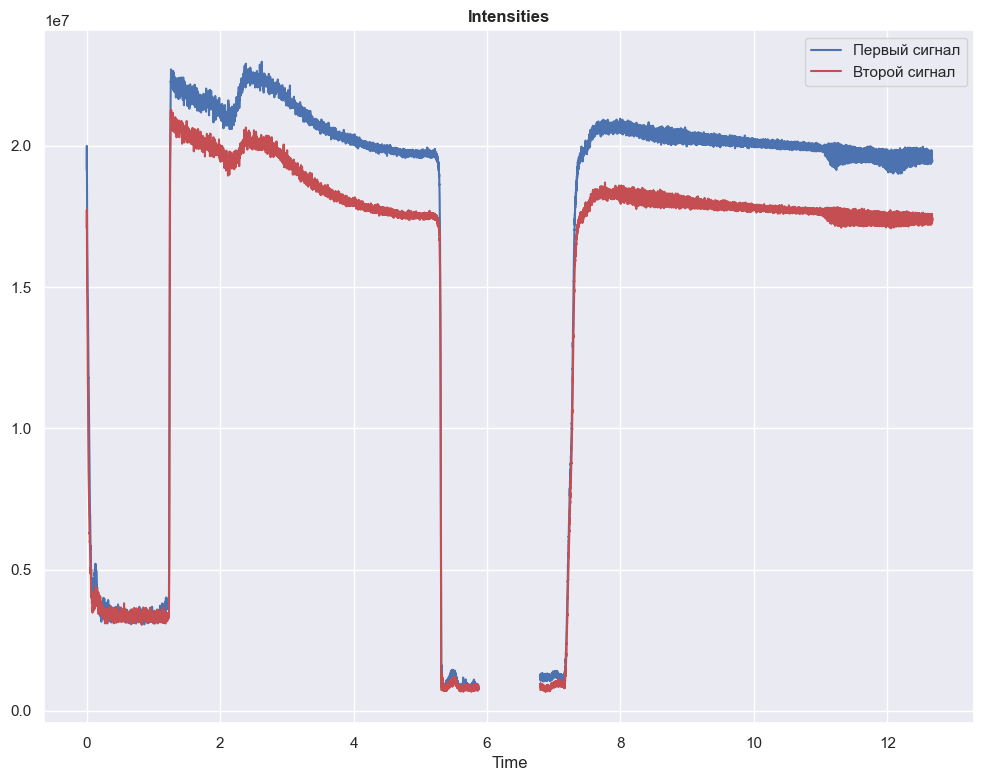

In [ ]:
plt.figure(figsize=(12, 9))

plt.plot(real_time[0]['first_half'], parameters_fct_rf[0]['first_half'].averaged_data.intensities, color='b', label='Первый сигнал')
plt.plot(real_time[0]['second_half'], parameters_fct_rf[0]['second_half'].averaged_data.intensities, color='b')

plt.plot(real_time[1]['first_half'], parameters_fct_rf[1]['first_half'].averaged_data.intensities, color='r', label='Второй сигнал')
plt.plot(real_time[1]['second_half'], parameters_fct_rf[1]['second_half'].averaged_data.intensities, color='r')

plt.xlabel('Time')
plt.title('Intensities',fontweight='bold')
plt.legend();

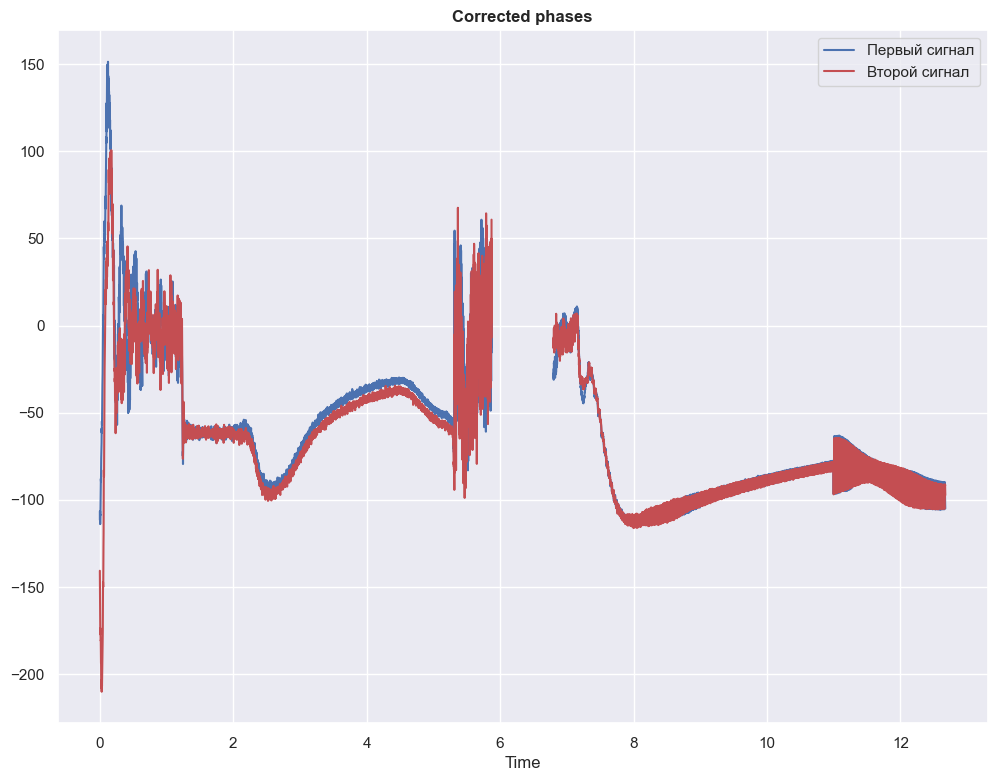

In [ ]:
plt.figure(figsize=(12, 9))

plt.plot(real_time[0]['first_half'], parameters_fct_rf[0]['first_half'].averaged_data.corrected_phases, color='b', label='Первый сигнал')
plt.plot(real_time[0]['second_half'], parameters_fct_rf[0]['second_half'].averaged_data.corrected_phases, color='b')

plt.plot(real_time[1]['first_half'], parameters_fct_rf[1]['first_half'].averaged_data.corrected_phases, color='r', label='Второй сигнал')
plt.plot(real_time[1]['second_half'], parameters_fct_rf[1]['second_half'].averaged_data.corrected_phases, color='r')

plt.xlabel('Time')
plt.title('Corrected phases',fontweight='bold')
plt.legend();

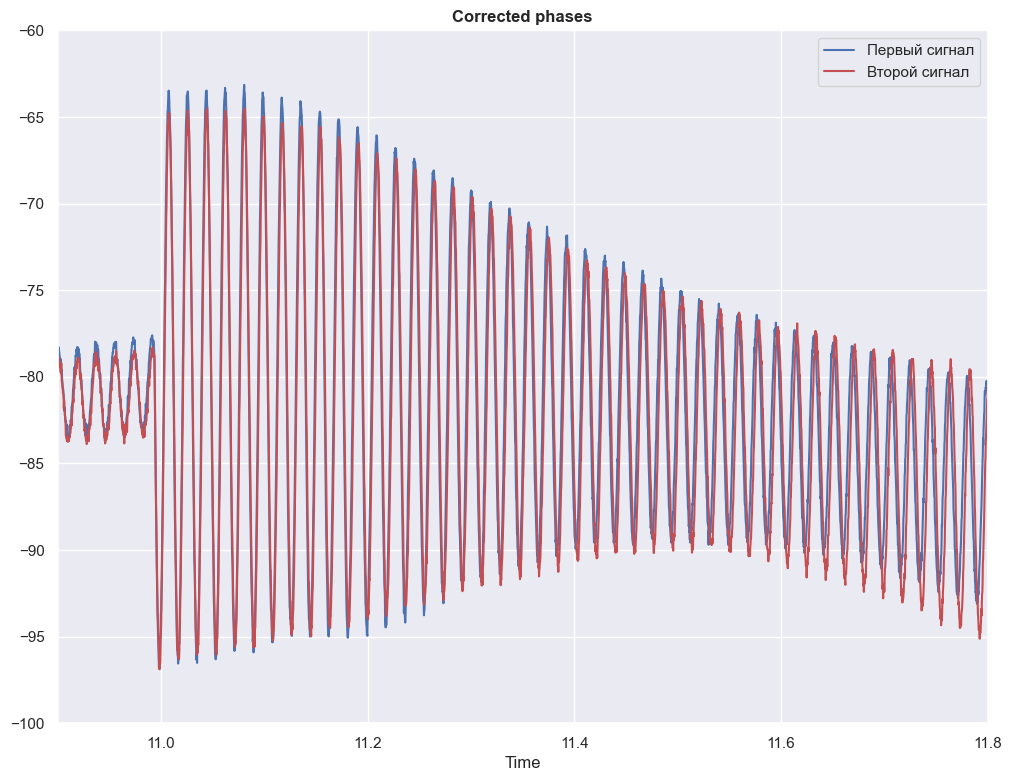

In [ ]:
plt.figure(figsize=(12, 9))

plt.plot(real_time[0]['first_half'], parameters_fct_rf[0]['first_half'].averaged_data.corrected_phases, color='b', label='Первый сигнал')
plt.plot(real_time[0]['second_half'], parameters_fct_rf[0]['second_half'].averaged_data.corrected_phases, color='b')

plt.plot(real_time[1]['first_half'], parameters_fct_rf[1]['first_half'].averaged_data.corrected_phases, color='r', label='Второй сигнал')
plt.plot(real_time[1]['second_half'], parameters_fct_rf[1]['second_half'].averaged_data.corrected_phases, color='r')

plt.xlabel('Time')
plt.title('Corrected phases',fontweight='bold')
plt.xlim([10.9, 11.8])
plt.ylim([-100, -60])
plt.legend();

# Тесты

In [ ]:
import pandas as pd

with open('Acceleration in Booster measured with FCT/BoosterAcceleration1_1half.dat', "rb") as file:
    parameters_from_dan = [
        {'first_half': pd.DataFrame(np.load(file).reshape(-1,3), columns=['Phases', 'Intensities', 'Corrected phases'])}]

with open('Acceleration in Booster measured with FCT/BoosterAcceleration1_2half.dat', "rb") as file:
    parameters_from_dan[0]['second_half'] = pd.DataFrame(np.load(file).reshape(-1,3), columns=['Phases', 'Intensities', 'Corrected phases'])

with open('Acceleration in Booster measured with FCT/BoosterAcceleration2_1half.dat', "rb") as file:
    parameters_from_dan.append({'first_half': pd.DataFrame(np.load(file).reshape(-1,3), columns=['Phases', 'Intensities', 'Corrected phases'])})

with open('Acceleration in Booster measured with FCT/BoosterAcceleration2_2half.dat', "rb") as file:
    parameters_from_dan[1]['second_half'] = pd.DataFrame(np.load(file).reshape(-1,3), columns=['Phases', 'Intensities', 'Corrected phases'])

In [ ]:
parameters_from_file = []
for p in parameters_fct_rf:
    dict_to_add = {}
    for key in half_names:
        dict_to_add[key] = pd.DataFrame(
            {'Phases': p[key].phases[phase_offset: -phase_offset],
            'Intensities': p[key].intensities,
            'Corrected phases': p[key].corrected_phases})
    parameters_from_file.append(dict_to_add)

In [ ]:
for i in range(len(parameters_from_file)):
    for key in half_names:
        print(i, key)
        print(len(parameters_from_dan[i][key]), len(parameters_from_file[i][key]))
        print((parameters_from_dan[i][key] - parameters_from_file[i][key]).max(), '\n')


0 first_half
124479 124479
Phases              0.000000e+00
Intensities         2.458692e-07
Corrected phases    1.847411e-12
dtype: float64 

0 second_half
355508 355508
Phases              0.000000e+00
Intensities         1.229346e-07
Corrected phases    7.105427e-13
dtype: float64 

1 first_half
124476 124476
Phases              0.000000e+00
Intensities         2.607703e-07
Corrected phases    3.694822e-12
dtype: float64 

1 second_half
355502 355502
Phases              0.000000e+00
Intensities         1.192093e-07
Corrected phases    7.815970e-13
dtype: float64 

